In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import torch
from torch import nn
from torcheval.metrics.functional import multiclass_f1_score

from helpers import get_hubert_features, unweighted_f1

In [2]:
# Get HuBERT features for one participant
hubert_features = get_hubert_features("P05")

  0%|          | 0/981 [00:00<?, ?it/s]

In [3]:
label_list = hubert_features["label_list"]
X_tr = hubert_features["X_tr"]
y_tr = hubert_features["y_tr"]
X_te = hubert_features["X_te"]

In [4]:
# Test that logistic regression gives the same results
# as a regularized neural network with no hidden layers
C = 0.02
est = make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=10**8))
est.fit(X_tr, y_tr)
pred_logistic = est.predict_proba(X_te)

model = nn.Sequential(nn.Linear(768, len(label_list)), nn.Softmax())
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

# Train the regularized network for many epochs. Every
# 1000 epochs, we compare predictions on the test set
# to the prediction from logistic regression, and we log
# the fraction of samples for which the predictions agree,
# and the maximum difference in predicted probabilities.
# We expect the fraction to approach 1.0 and the maximum
# difference to approach 0.0 as the number of training
# epochs grows.
num_epochs = 10000
for epoch_number in range(num_epochs):
    pred = model(X_tr)
    std_by_feature = X_tr.std(0)

    # Training loss is categorical cross-entropy plus an L^2
    # regularization term
    loss = nn.NLLLoss()(pred.log(), y_tr)
    loss += (
        (next(next(model.children()).parameters()) * std_by_feature) ** 2
    ).sum() / (2 * C * len(X_tr))

    # Update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Compare the networks predictions on test set to
    # the logistic regression model
    if (1 + epoch_number) % 1000 == 0:
        with torch.no_grad():
            pred = model(X_te)
            print(
                f"Epoch {1+epoch_number}, "
                f"agreement {(pred.numpy().argmax(1) == pred_logistic.argmax(1)).mean():,.4f}, "
                f"max difference {np.abs(pred.numpy() - pred_logistic).max():,.4f}"
            )

/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/jr/miniconda3/envs/ml_311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1000, agreement 0.9643, max difference 0.2224
Epoch 2000, agreement 0.9773, max difference 0.1564
Epoch 3000, agreement 0.9838, max difference 0.1090
Epoch 4000, agreement 0.9903, max difference 0.0687
Epoch 5000, agreement 0.9968, max difference 0.0387
Epoch 6000, agreement 0.9935, max difference 0.0186
Epoch 7000, agreement 1.0000, max difference 0.0093
Epoch 8000, agreement 1.0000, max difference 0.0045
Epoch 9000, agreement 1.0000, max difference 0.0023
Epoch 10000, agreement 1.0000, max difference 0.0016


### Multi-layer networks

Above, we saw that a network with no hidden layers and L^2 regularization is
equivalent to regularized logistic regression. Next, we will add some hidden
layers to the network. Since our dataset is relatively small, using a simple
validation set to determine when to halt training will introduce large variance.
Instead, we cross-validate using the following methodology:
 - Initialize network weights randomly
 - Clone the network for each CV fold
 - Train each network on its respective training folds, and make
predictions on the respective test folds
 - Assemble out-of-sample test fold predictions and compute unweighted f1 score associated with each epoch
 - Halt the training once the out-of-sample unweighted f1 score peaks (we average scores over a rolling window of 9 consecutive epochs to reduce noise)
 - For inference on the test set, retrain a network starting with the same initial weights using the entire training set, using the determined number of training epochs

In [5]:
np.random.seed(12345)
test_folds = np.random.randint(0, 10, len(X_tr))

  0%|          | 0/300 [00:00<?, ?it/s]

0.6201506 122


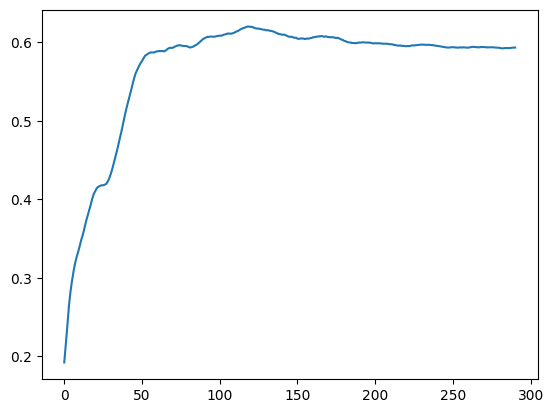

In [6]:
hidden_size = 16
torch.manual_seed(12345)
base_model = nn.Sequential(
    nn.Linear(768, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, len(label_list)),
    nn.Softmax(),
)

model_dict = {}
opt_dict = {}
for test_fold in np.unique(test_folds):
    model = deepcopy(base_model)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
    model_dict[test_fold] = model
    opt_dict[test_fold] = opt

scores = []
for n in tqdm(range(300)):
    pred = torch.zeros(len(X_tr), len(label_list))
    for fold, model in model_dict.items():
        opt = opt_dict[fold]
        mask = test_folds == fold
        std_by_feature = X_tr[~mask].std(0)
        loss = nn.NLLLoss()(model(X_tr[~mask]).log(), y_tr[~mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            pred[mask] = model(X_tr[mask])
    score = multiclass_f1_score(
        pred, y_tr, average="macro", num_classes=len(label_list)
    )
    scores.append(score)
scores = np.array(scores)
smoothed_scores = sum(scores[n : -9 + n] for n in range(9)) / 9
print(np.max(smoothed_scores), np.argmax(smoothed_scores) + 4)
plt.plot(smoothed_scores)
plt.show()

In [7]:
torch.manual_seed(0)
model = nn.Sequential(
    nn.Linear(768, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, len(label_list)),
    nn.Softmax(),
)
opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
for n in tqdm(range(130)):
    mask = test_folds == fold
    std_by_feature = X_tr[~mask].std(0)
    loss = nn.NLLLoss()(model(X_tr[~mask]).log(), y_tr[~mask])
    loss += (
        (next(next(model.children()).parameters()) * std_by_feature) ** 2
    ).sum() / (2 * C * (~mask).sum())
    opt.zero_grad()
    loss.backward()
    opt.step()

  0%|          | 0/130 [00:00<?, ?it/s]

In [8]:
X_te, y_te = hubert_features["X_te"], hubert_features["y_te"]
with torch.no_grad():
    pred = model(X_te).argmax(1)
print("f1 score, all test:", unweighted_f1(y_te, pred))
session_tr = hubert_features["session_tr"]
session_te = hubert_features["session_te"]
small_session_mask = ~pd.Series(session_te).isin(session_tr)
print(
    "f1 score, holdout sessions:",
    unweighted_f1(y_te[small_session_mask], pred[small_session_mask]),
)
print(
    "f1 score, sessions shared with training data:",
    unweighted_f1(y_te[~small_session_mask], pred[~small_session_mask]),
)

f1 score, all test: 0.5449
f1 score, holdout sessions: 0.3638
f1 score, sessions shared with training data: 0.6192


In [9]:
# Heatmap for test predictions
conf_mat = confusion_matrix(pred, y_te)
display(pd.DataFrame(conf_mat, label_list, label_list))
plt.figure(figsize=(7, 7))
plt.imshow(conf_mat, cmap="viridis", interpolation="nearest")
plt.xticks(range(len(label_list)), labels=label_list)
plt.yticks(range(len(label_list)), labels=label_list)
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.show()

NameError: name 'confusion_matrix' is not defined